In [1]:
import numpy as np
import itertools
import random
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from jenga.cleaning.ppp import PipelineWithPPP
from jenga.cleaning.autoclean import AutoClean
from jenga.cleaning.outlier_removal import SKLearnIsolationForest
from jenga.cleaning.imputation import SimpleImputation

from jenga.corruptions.categorical import SwapValues
from jenga.corruptions.numeric import SwappedValues, Outliers, Scaling
from jenga.corruptions.text import BrokenCharacters
from jenga.corruptions.missing import ( MissingValuesHighEntropy, 
                                  MissingValuesLowEntropy, 
                                  MissingValues
                                )

%load_ext autoreload
%autoreload 2


# Titanic Example

In [2]:

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


In [3]:
perturbation = Scaling(0.2, ['age','fare'])
# perturbation = SwappedValues(0.4, ['age','fare'])
# perturbation = MissingValues(0.7, 'fare',0,'MAR')
X_corrupted = perturbation(X_test.copy())

ac = AutoClean(X_train, 
               y_train, 
               clf,
               numeric_columns=numeric_features,
               categorical_columns=categorical_features
              )

X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': predicted_score_no_cleaning,
        'ppp_score_cleaned': np.array(cleaner_results_ppp).max()
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

perturbation:Scaling: {'fraction': 0.2, 'columns': ['age', 'fare']}
clean_data_test_score:0.7900763358778626
corrupted_data_test_score:0.7175572519083969
cleaned_data_test_score:0.7175572519083969
ppp_score_corrupted:0.7161413562559693
ppp_score_cleaned:0.7505253104106973


In [4]:
cleaner_results_ppp, cleaner_results_true

([0.7161413562559693,
  0.7505253104106973,
  0.7161413562559693,
  0.7074180197389367],
 [0.7175572519083969,
  0.7175572519083969,
  0.7175572519083969,
  0.7061068702290076])

# Toy Data Example

(-1.8774763389668039, 4.73916889797604, -1.7047546030348233, 6.633577833428513)

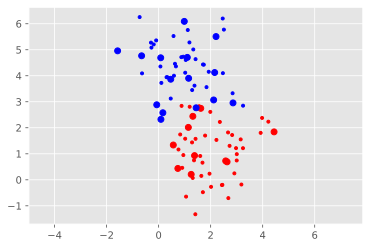

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_test.loc[y_test>0,0],X_test.loc[y_test>0,1],'ro',
         X_test.loc[y_test<=0,0],X_test.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

(-1.8774763389668039, 4.73916889797604, -2.6982524435588995, 7.594105043476921)

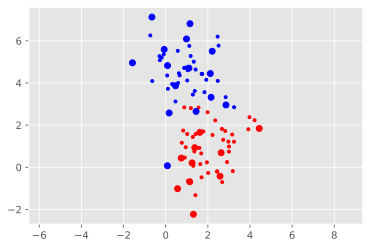

In [6]:
perturbation = Outliers(0.5, [1])
X_corrupted = perturbation(X_test.copy())

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_corrupted.loc[y_test>0,0],X_corrupted.loc[y_test>0,1],'ro',
         X_corrupted.loc[y_test<=0,0],X_corrupted.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

In [7]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = [0,1]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf = clf.fit(X_train, y_train)
print(f'Clean Test Score {clf.score(X_test, y_test)}')
print(f'Corrupted Test Score {clf.score(X_corrupted, y_test)}')

Clean Test Score 0.88
Corrupted Test Score 0.88


In [8]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numeric_columns=numeric_features, 
                      categorical_columns=[],
                      num_repetitions=5,
                      perturbation_fractions=[.1,.3, .5, .6, .75, .9, .99]
                     )

ppp.fit_ppp(X_train, y_train)
print(f'Predicted clean score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
print(f'Predicted corrupted score: {ppp.predict_ppp(X_corrupted):.4f}, true score {clf.score(X_corrupted, y_test):.4f}')


Predicted clean score: 0.8782, true score 0.8800
Predicted corrupted score: 0.9138, true score 0.8800


In [9]:
ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numeric_columns=[0,1], 
               categorical_columns=[]
              )
X_cleaned, predicted_score, cleaner_results_ppp, cleaner_results_true  = ac(X_corrupted.copy(deep=True), y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

perturbation:Outliers: {'fraction': 0.5, 'columns': [1]}
clean_data_test_score:0.88
corrupted_data_test_score:0.88
cleaned_data_test_score:0.88
ppp_score_corrupted:0.9137777777777778
ppp_score_cleaned:0.9137777777777778


In [10]:
cleaner_results_ppp, cleaner_results_true

([0.8711111111111112,
  0.8497777777777779,
  0.8711111111111112,
  0.8497777777777779],
 [0.88, 0.8, 0.88, 0.8])

# OpenML Example

In [11]:
corruptions = {
    'numeric':[Outliers, Scaling],
    'categorical':[SwapValues],
    'missing': [MissingValuesHighEntropy, 
                MissingValuesLowEntropy, 
                MissingValues]
}

def get_random_perturbation(numerical_columns, 
                            categorical_columns, 
                            fractions=[.2, .5, .7, .9]):
    '''
    Returns a random perturbation, chosen from either a numeric (swapping, outlier, scaling)
    or missingness
    '''
    
    if len(numerical_columns)>0 and len(categorical_columns)>0:
        perturbation_type = random.choice(list(corruptions.keys()))
    elif len(numerical_columns)>0:
        perturbation_type = 'numeric'
    elif len(categorical_columns)>0:
        perturbation_type = 'categorical'
    else:
        print("need at least one categorical or numeric column")
        
    random_fraction = random.choice(fractions)
    if perturbation_type is 'missing':
        missingness = random.choice(['MCAR', 'MAR', 'MNAR'])
        rand_column = random.choice(categorical_columns + numerical_columns)
        if rand_column in numerical_columns:
            missing_value = 0
        else:
            missing_value = ''
        return MissingValues(random_fraction, rand_column, missing_value, missingness)
    elif perturbation_type is 'numeric':
        perturbation = random.choice(corruptions[perturbation_type])
        rand_column = random.choice(numerical_columns)
        return perturbation(random_fraction, [rand_column])
    elif perturbation_type is 'categorical':
        rand_column = random.choice(categorical_columns)
        return SwapValues(random_fraction, rand_column)

# https://www.openml.org/search?q=qualities.NumberOfClasses%3A2%2520qualities.NumberOfInstances%3A100..10000%2520qualities.NumberOfFeatures%3A10..100&type=data
experiments = [
    'ionosphere',
    'sonar',
    'heart-statlog',
    'parkinsons',
    'KnuggetChase3',
    'Satellite',
    'fertility',
    'steel-plates-fault',
    'profb',
    'sick',
    'credit-g',
    'churn',
#     'bank-marketing',
    'cleve',
    'mushroom',
    'colic',
    'soybean'
 ]


In [12]:
def run_experiment(exp_id, n_perturbations=3):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    n_perturb = np.random.randint(1,n_perturbations)
    print(f'Applying {n_perturb} perturbations')
    X_corrupted = X_test.copy()
    for _ in range(n_perturb):
        perturbation = get_random_perturbation(numeric_features, categorical_features)
        print(perturbation)
        X_corrupted = perturbation(X_corrupted)

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numeric_columns=numeric_features, 
                   categorical_columns=categorical_features
                  )
    
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': predicted_score_no_cleaning,
            'ppp_score_cleaned': np.array(cleaner_results_ppp).max(),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result

In [13]:
results = []
for _ in range(20):
    results.append(run_experiment(random.choice(experiments)))

********************************************************************************
Fetching dataset soybean
Found 35 categorical and 0 numeric features
model score: 0.956
Applying 2 perturbations
SwapValues: {'fraction': 0.7, 'column': 'germination'}
SwapValues: {'fraction': 0.2, 'column': 'crop-hist'}


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


perturbation:SwapValues: {'fraction': 0.2, 'column': 'crop-hist'}
clean_data_test_score:0.9562043795620438
corrupted_data_test_score:0.9635036496350365
cleaned_data_test_score:0.9635036496350365
ppp_score_corrupted:0.968009768009768
ppp_score_cleaned:0.968009768009768
cleaner_results_ppp:[0.968009768009768, 0.9675213675213675, 0.9658119658119658, 0.9617826617826618]
cleaner_results_true:[0.9635036496350365, 0.8905109489051095, 0.8029197080291971, 0.7883211678832117]
********************************************************************************
Fetching dataset churn
Found 4 categorical and 16 numeric features
model score: 0.867
Applying 1 perturbations
SwapValues: {'fraction': 0.7, 'column': 'number_customer_service_calls'}


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


perturbation:SwapValues: {'fraction': 0.7, 'column': 'number_customer_service_calls'}
clean_data_test_score:0.867
corrupted_data_test_score:0.846
cleaned_data_test_score:0.846
ppp_score_corrupted:0.8354833333333335
ppp_score_cleaned:0.8552666666666666
cleaner_results_ppp:[0.8354833333333335, 0.8552666666666666, 0.8354833333333335, 0.8530333333333332]
cleaner_results_true:[0.846, 0.846, 0.846, 0.846]
********************************************************************************
Fetching dataset fertility
Found 0 categorical and 9 numeric features
model score: 0.950
Applying 1 perturbations
Scaling: {'fraction': 0.9, 'columns': ['V4']}
perturbation:Scaling: {'fraction': 0.9, 'columns': ['V4']}
clean_data_test_score:0.95
corrupted_data_test_score:0.95
cleaned_data_test_score:0.95
ppp_score_corrupted:0.8616666666666668
ppp_score_cleaned:0.8616666666666668
cleaner_results_ppp:[0.8616666666666668, 0.8616666666666668, 0.8616666666666668, 0.8616666666666668]
cleaner_results_true:[0.95, 0.95,

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


model score: 0.949
Applying 2 perturbations
SwapValues: {'fraction': 0.2, 'column': 'seed'}
SwapValues: {'fraction': 0.9, 'column': 'plant-stand'}
perturbation:SwapValues: {'fraction': 0.9, 'column': 'plant-stand'}
clean_data_test_score:0.948905109489051
corrupted_data_test_score:0.9562043795620438
cleaned_data_test_score:0.9562043795620438
ppp_score_corrupted:0.9606837606837607
ppp_score_cleaned:0.9606837606837607
cleaner_results_ppp:[0.9606837606837607, 0.95995115995116, 0.9533577533577534, 0.9537240537240538]
cleaner_results_true:[0.9562043795620438, 0.8905109489051095, 0.7883211678832117, 0.781021897810219]
********************************************************************************
Fetching dataset Satellite
Found 0 categorical and 36 numeric features
model score: 0.991
Applying 2 perturbations
Scaling: {'fraction': 0.9, 'columns': ['V12']}
Outliers: {'fraction': 0.5, 'columns': ['V35']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['V35']}
clean_data_test_score:0.99117

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


perturbation:MissingValues: {'column': 'phone_number', 'fraction': 0.5, 'na_value': 0, 'missingness': 'MNAR'}
clean_data_test_score:0.869
corrupted_data_test_score:0.867
cleaned_data_test_score:0.867
ppp_score_corrupted:0.8555333333333331
ppp_score_cleaned:0.8555333333333331
cleaner_results_ppp:[0.8555333333333331, 0.8530833333333331, 0.8555333333333331, 0.8518666666666665]
cleaner_results_true:[0.867, 0.865, 0.867, 0.865]
********************************************************************************
Fetching dataset cleve
Found 8 categorical and 5 numeric features
model score: 0.836
Applying 2 perturbations
Scaling: {'fraction': 0.5, 'columns': ['Max_heart_rate']}
Outliers: {'fraction': 0.2, 'columns': ['Oldpeak']}
perturbation:Outliers: {'fraction': 0.2, 'columns': ['Oldpeak']}
clean_data_test_score:0.8360655737704918
corrupted_data_test_score:0.5901639344262295
cleaned_data_test_score:0.5573770491803278
ppp_score_corrupted:0.7305785123966941
ppp_score_cleaned:0.7418732782369145
cl

In [14]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')

In [15]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')
cleaner_ppp = list(itertools.chain(*df_results['cleaner_results_ppp']))
cleaner_true = list(itertools.chain(*df_results['cleaner_results_true']))

In [27]:
np.vstack(df_results['cleaner_results_ppp']).shape

(20, 4)

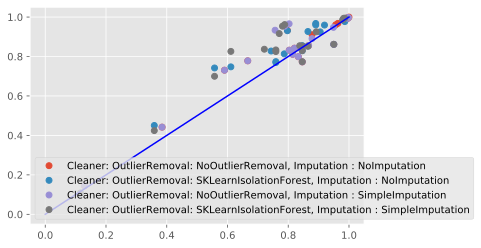

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')
# cleaner_ppp = list(itertools.chain(*df_results['cleaner_results_ppp']))
# cleaner_true = list(itertools.chain(*df_results['cleaner_results_true']))
# plt.plot(cleaner_true, cleaner_ppp, '.',[0,1],[0,1],'b-')
cleaner_ppp = np.vstack(df_results['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results['cleaner_results_true'])
plt.plot(cleaner_true, cleaner_ppp, 'o')
plt.legend(ac.cleaners, loc='lower left')
plt.plot([0,1],[0,1],'b-')

In [17]:
def run_experiment_nonlinear(exp_id, n_perturbations=3):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")

    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])

    
    param_grid = {
            'n_estimators': np.arange(5, 100, 10)
        }

    classifier = GridSearchCV(RandomForestClassifier(), param_grid)
        
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    n_perturb = np.random.randint(1,n_perturbations)
    print(f'Applying {n_perturb} perturbations')
    X_corrupted = X_test.copy()
    for _ in range(n_perturb):
        perturbation = get_random_perturbation(numeric_features, categorical_features)
        print(perturbation)
        X_corrupted = perturbation(X_corrupted)

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numeric_columns=numeric_features, 
                   categorical_columns=categorical_features
                  )
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': predicted_score_no_cleaning,
            'ppp_score_cleaned': np.array(cleaner_results_ppp).max(),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result
    

In [18]:
results_nonlinear = []
for _ in range(30):
    results_nonlinear.append(run_experiment_nonlinear(random.choice(experiments)))

df_results_nonlinear = pd.DataFrame(results_nonlinear)
df_results_nonlinear.to_csv('results_nonlinear.csv')

********************************************************************************
Fetching dataset sick
Found 22 categorical and 7 numeric features
model score: 0.977
Applying 2 perturbations
MissingValues: {'column': 'T3', 'fraction': 0.2, 'na_value': 0, 'missingness': 'MCAR'}
SwapValues: {'fraction': 0.7, 'column': 'T4U_measured'}
perturbation:SwapValues: {'fraction': 0.7, 'column': 'T4U_measured'}
clean_data_test_score:0.9774834437086093
corrupted_data_test_score:0.8079470198675497
cleaned_data_test_score:0.8039735099337748
ppp_score_corrupted:0.824163075903215
ppp_score_cleaned:0.8334106728538283
cleaner_results_ppp:[0.824163075903215, 0.8334106728538283, 0.8207711855043642, 0.8332780908186941]
cleaner_results_true:[0.8079470198675497, 0.8039735099337748, 0.8039735099337748, 0.8013245033112583]
********************************************************************************
Fetching dataset steel-plates-fault
Found 0 categorical and 33 numeric features
model score: 0.985
Applying 1 

model score: 0.991
Applying 2 perturbations
MissingValues: {'column': 'psych', 'fraction': 0.5, 'na_value': '', 'missingness': 'MCAR'}
MissingValues: {'column': 'TSH_measured', 'fraction': 0.5, 'na_value': '', 'missingness': 'MNAR'}
perturbation:MissingValues: {'column': 'TSH_measured', 'fraction': 0.5, 'na_value': '', 'missingness': 'MNAR'}
clean_data_test_score:0.990728476821192
corrupted_data_test_score:0.9894039735099338
cleaned_data_test_score:0.9894039735099338
ppp_score_corrupted:0.9806761683791846
ppp_score_cleaned:0.9806761683791846
cleaner_results_ppp:[0.9806761683791846, 0.9502154458070932, 0.9806761683791846, 0.952038448790189]
cleaner_results_true:[0.9894039735099338, 0.9841059602649007, 0.9894039735099338, 0.9841059602649007]
********************************************************************************
Fetching dataset colic
Found 19 categorical and 7 numeric features
model score: 0.905
Applying 2 perturbations
Scaling: {'fraction': 0.9, 'columns': ['nasogastric_reflux

model score: 0.741
Applying 1 perturbations
Scaling: {'fraction': 0.9, 'columns': ['resting_electrocardiographic_results']}
perturbation:Scaling: {'fraction': 0.9, 'columns': ['resting_electrocardiographic_results']}
clean_data_test_score:0.7407407407407407
corrupted_data_test_score:0.7407407407407407
cleaned_data_test_score:0.7407407407407407
ppp_score_corrupted:0.9333333333333333
ppp_score_cleaned:0.9333333333333333
cleaner_results_ppp:[0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]
cleaner_results_true:[0.7407407407407407, 0.6851851851851852, 0.7407407407407407, 0.6851851851851852]
********************************************************************************
Fetching dataset fertility
Found 0 categorical and 9 numeric features
model score: 0.950
Applying 1 perturbations
Outliers: {'fraction': 0.5, 'columns': ['V9']}
perturbation:Outliers: {'fraction': 0.5, 'columns': ['V9']}
clean_data_test_score:0.95
corrupted_data_test_score:0.95
cleaned_data_te

In [19]:
debug

2020-03-23 19:29:35,174 [ERROR]  No traceback has been produced, nothing to debug.


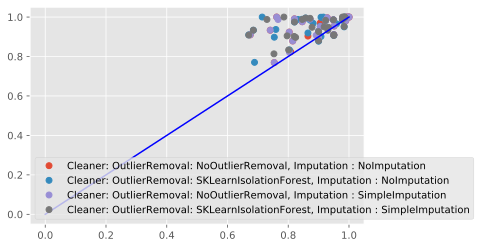

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# cleaner_ppp = list(itertools.chain(*df_results_nonlinear['cleaner_results_ppp']))
# cleaner_true = list(itertools.chain(*df_results_nonlinear['cleaner_results_true']))
# plt.plot(cleaner_true, cleaner_ppp, '.',[0,1],[0,1],'b-')
cleaner_ppp = np.vstack(df_results_nonlinear['cleaner_results_ppp'])
cleaner_true = np.vstack(df_results_nonlinear['cleaner_results_true'])
plt.plot(cleaner_true, cleaner_ppp, 'o')
plt.legend(ac.cleaners, loc='lower left')
plt.plot([0,1],[0,1],'b-')

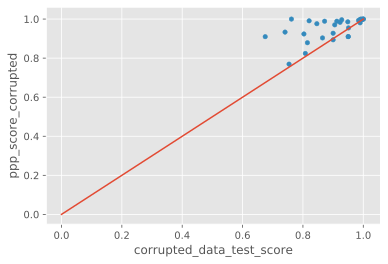

In [24]:
df_results_nonlinear.plot.scatter('corrupted_data_test_score','ppp_score_corrupted')
plt.plot([0,1],[0,1],'-')